# Discretizing Hamiltonians and computing a spectrum

## Tight-binding models

Kwant is designd to work with what commonly is called a "tight-binding" model. In practice, what we mean by that is that the Hamiltonian has a set of *discrete* degrees of freedom, i.e. that it can be written as

$$
H = \sum_{ij} \, t_{ij}\, \left|i\rangle\langle j\right|
$$

The states $\left|i \right>$ will typically correspond to sites on a lattice and additional
degrees of freedom, such as orbitals, spin, ...

Let's look at a few examples!

### Graphene

A tight-binding model originates naturally when describing materials in terms of atomic orbitals on a lattice. Electrons can then only hop to neighboring orbitals, forexample in graphene between $p_z$-orbitals:

<img src="images/graphene.svg" style="width: 50%">

The value of the hopping parameters must then be taken from experiment/DFT calculations ...

### Finite differences for continuum Hamiltonians

####  Discretizing a 1D Hamiltonian

Quite often, the starting point of a study is not a tight-binding Hamiltonian, but a continuum Hamiltonian such as

$$H = -\frac{\hbar^2}{2 m^*} \frac{d^2}{dx^2}$$

(for simplicity, we start with a 1D example, and generalize to higher dimensions later)

So how can we solve this in kwant?

The usual trick is to use the method of *finite differences*. We approximate:

$$ \frac{d \psi(x)}{d x} \approx \frac{\psi(x+a) - \psi(x-a)}{2a}$$

$$ \frac{d \psi(x)}{d x^2} \approx \frac{2 \psi(x) - \psi(x-a) - \psi(x+a)}{a^2}$$

We see that now only the wave function at points that are spaced by $a$ are entering here. Hence we can replace the continuous coordinate space by a discrete lattice with lattice spacing $a$:

<img src="images/discretization.svg" style="width: 70%">

where $x_i = i a$

In the finite difference approximation, the Schrödinger equation then reads

$$ H \psi(x_i) = \frac{\hbar^2}{2 m^* a^2} \left[2 \psi(x_i) - \psi(x_i-a) - \psi(x_i+a) \right] = E \psi(x_i) $$

It is useful to define the quantity $t = \frac{\hbar^2}{2 m^* a^2}$ which has units of energy (and depends on the lattice constant $a$)

We have now everything to turn our continuum Hamiltonian into a tight-binding version. We use the lattice points $x_i$ as a basis: $\left|x_i \right>$. How can we now read off the values of the onsite and hopping enerrgies from the finite difference equation?

When the Hamiltonian acts on a wave function, it "brings" the value of the wave function from some neighboring lattice point to the lattice point $x_i$ (see the right-hand side $E \psi(x_i)$). Hence, if we find a term proportional to $t \psi(x_j)$ in the finite difference
equation, this corresponds to a hopping energy *from* $x_j$ *to* $x_i$, i.e. a tight-binding term $t \left|x_i \rangle \langle x_j\right|$.

In our simple example we can thus read off:
- onsite energy: $2 t$
- hopping between nearest neighbors $-t$

We thus finally end up with a tight-binding system that looks like this:

<img src="images/tb_1d.svg" style="width: 40%">

#### Discretizing in higher dimensions

The generalization to higher dimensions is straight-forward: For

$$H = -\frac{\hbar^2}{2 m^*} \nabla^2 $$

we find
- onsite energy $4 t$ (in 2D) or $6 t$ (in 3D)
- hopping energy $-t$ for hopping between neighbors in $x$, $y$ and $z$-direction

(*Control question: Why does the onsite energy depend on dimensionality?*)


#### Validity of the finite difference approximation

Obviously, the discretization only works if it is fine enough. In particular, it must be fine enough to capture the changes in the wave function, i.e. $a \ll \lambda_F$. In practice, a good rool of thumb is that the approximation is good for energies $E \lesssim t$

## The first kwant system!

Let's now put our knowledge into practice! Let's first activate kwant:

In [1]:
import kwant

/anaconda3/lib/python3.6/site-packages/kwant-1.4.0a0.dev27+g5844d3c-py3.6-macosx-10.7-x86_64.egg/kwant/solvers/default.py:18: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  "Performance can be very poor in this case.", RuntimeWarning)


Yes it's as easy as that!

We'll do some more import of things we need later

In [2]:
%run matplotlib_setup.ipy

import scipy.linalg as la

We will describe a particle in 2D with the Hamiltonian $H= -\frac{\hbar^2}{2m^*} \nabla^2$. The finite difference approach thus yields a *square lattice* with lattice constant $a$ (which we will set to 1). So in kwant we do:

In [3]:
lat = kwant.lattice.square(a=1)

We want to confine the electrons in a finite region. Here, we choose a circle

In [4]:
t = 1
r = 15

def circle(pos):
    x, y = pos
    return x**2 + y**2 < r**2

sys = kwant.Builder()
sys[lat.shape(circle, (0,0))] = 4 * t
sys[lat.neighbors()] = -t

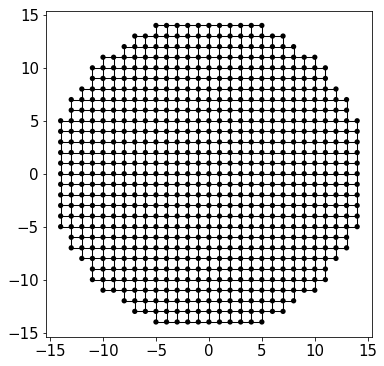

In [5]:
kwant.plot(sys);

Once we are finished building the kwant system, we "finalize" it: this means the system will be brought into a format better suited for doing calculations, and it's shape cannot
be changed any more (its values still can - see later tutorial)

In [6]:
sys = sys.finalized()

Building a kwant system means defining the Hamiltonian! We can get it from the finalized kwant system:

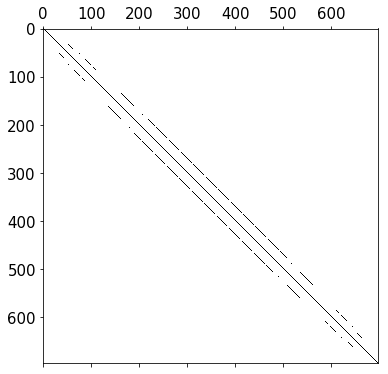

In [7]:
ham = sys.hamiltonian_submatrix()
plt.matshow(ham==0, cmap="gray", interpolation=None)

But now we can start doing nice things! For example, we can now compute the eigenvalues and eigefunctions of this system very easily.

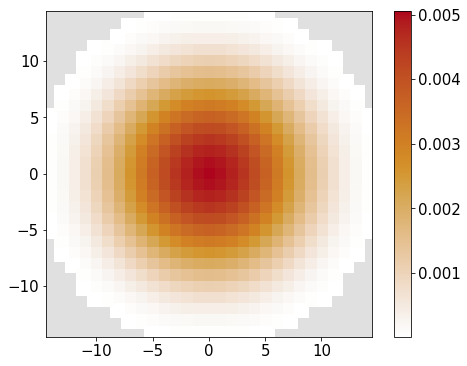

In [8]:
eval, evec = la.eigh(ham)

kwant.plotter.map(sys, abs(evec[:,0])**2);

Let's use some ipython magic and make an interactive plot showing the first 30 wave functions

In [9]:
from ipywidgets import interact

def plot_wf(i=0):
    print("Plotting wave function with index", i)
    print("energy:", eval[i],"x t") 
    kwant.plotter.map(sys, abs(evec[:, i])**2)
    
interact(plot_wf, i=(0, 30))

A Jupyter Widget

<function __main__.plot_wf>

## Your turn!

Modify the code shown above and play with some possibilities. For example, you could:

- Change the shape of the confined region. The circle has a rotational symmetry, which leads
to degenerate eigenvalues (well, due to the discretization rather nearly degenerate). Take a shape that breaks this symmetry! For example, an ellipse can be defined through the equation $(x/r_1)^2+(y/r_2)^2 < 1$
- Above, we made a homogeneous circle. With ``kwant.Builder()``, you can also make things position-dependent. For example, try to add an additional potential at site `(i,j)` using, say,
``sys[lat(i, j)] = 8 * t``
- Try to cut a hole in the above example. You could do this either by modifying the circle
function, or by deleting points using ``del``.
- Plot also the higher wave functions! At which point do they stop looking like you would expect it? Is this in agreement with the criterion for validity of the finite difference approximation?

In [60]:
lat = kwant.lattice.square(a=1)

In [61]:
t = 1
r1 = 30
r2 = 30

def ellipse(pos):
    x, y = pos
    return x**2/r1**2 + y**2/r2**2 < 1

sys = kwant.Builder()
#ps1=5
#ps2=-3
sys[lat.shape(ellipse, (0,0))] = 0 #8 * t
sys[lat.neighbors()] = t

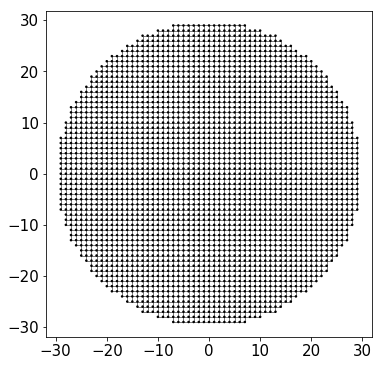

In [62]:
kwant.plot(sys);

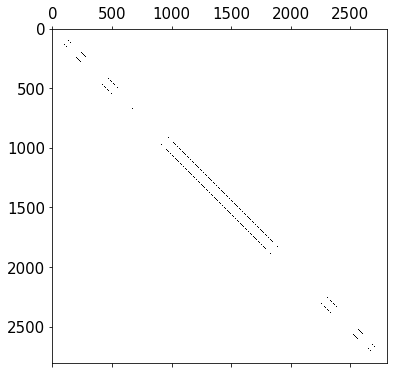

In [63]:
sys = sys.finalized()
ham = sys.hamiltonian_submatrix()
plt.matshow(ham==0, cmap="gray", interpolation=None)

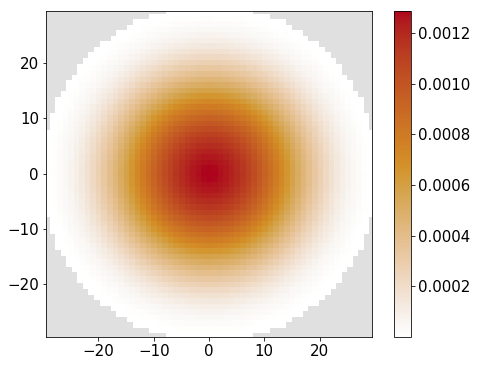

In [64]:
eval, evec = la.eigh(ham)

kwant.plotter.map(sys, abs(evec[:,0])**2);

In [19]:
from ipywidgets import interact

def plot_wf(i=0):
    print("Plotting wave function with index", i)
    print("energy:", eval[i],"x t") 
    kwant.plotter.map(sys, abs(evec[:, i])**2)
    
interact(plot_wf, i=(0, 30))

A Jupyter Widget

<function __main__.plot_wf>